In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def load_data():
    """Load and prepare data"""
    # Load stock data
    stocks = pd.read_csv('SP500-stocks-1.csv')
    stocks.set_index('Unnamed: 0', inplace=True)
    stocks.index = pd.to_datetime(stocks.index, format='%d/%m/%Y')
    
    # Load market data
    market = pd.read_csv('SP500-index-1.csv')
    market['SP500'] = market['SP500'].str.replace(',', '').astype(float)
    market['Date'] = pd.to_datetime(market['Date'], format='%d-%b-%y')
    market.set_index('Date', inplace=True)
    
    return stocks, market['SP500']

In [22]:
def find_top_50_stocks(prices):
    """Find top 50 stocks based on different criteria"""
    returns = prices.pct_change().dropna()
    metrics = pd.DataFrame(index=returns.columns)
    
    # 1. Risk (standard deviation)
    metrics['Risk'] = returns.std()
    least_risky = metrics.nsmallest(50, 'Risk').index
    
    # 2. Growth (cumulative return)
    metrics['Growth'] = (1 + returns).prod() - 1
    highest_growth = metrics.nlargest(50, 'Growth').index
    
    # 3. Performance (Sharpe ratio)
    metrics['Sharpe'] = returns.mean() / returns.std()
    best_performance = metrics.nlargest(50, 'Sharpe').index
    
    return {
        'least_risky': least_risky,
        'highest_growth': highest_growth,
        'best_performance': best_performance,
        'metrics': metrics
    }

In [23]:
class PortfolioOptimizer:
    def __init__(self, returns, market_returns, selected_stocks):
        self.returns = returns[selected_stocks]
        self.market_returns = market_returns
        self.selected_stocks = selected_stocks
        self.n_assets = len(selected_stocks)
        
        # Calculate basic metrics
        self.cov_matrix = self.returns.cov()
        self.exp_returns = self.returns.mean()
        
        # Calculate CAPM parameters
        self.calculate_capm_parameters()
    
    def calculate_capm_parameters(self):
        """Calculate CAPM parameters"""
        market_var = self.market_returns.var()
        market_mean = self.market_returns.mean()
        
        self.betas = pd.Series(index=self.selected_stocks)
        self.alphas = pd.Series(index=self.selected_stocks)
        
        for stock in self.selected_stocks:
            beta = self.returns[stock].cov(self.market_returns) / market_var
            alpha = self.returns[stock].mean() - beta * market_mean
            
            self.betas[stock] = beta
            self.alphas[stock] = alpha
        
        self.capm_exp_returns = market_mean * self.betas + self.alphas
        self.capm_cov = np.outer(self.betas, self.betas) * market_var
    
    def equal_weight(self):
        """Equal weight portfolio"""
        return pd.Series(1/self.n_assets, index=self.selected_stocks)
    
    def optimal_portfolio(self, allow_short=False, use_capm=False):
        """Optimize portfolio for maximum Sharpe ratio"""
        exp_rets = self.capm_exp_returns if use_capm else self.exp_returns
        cov_mat = self.capm_cov if use_capm else self.cov_matrix
        
        def neg_sharpe_ratio(weights):
            weights = pd.Series(weights, index=self.selected_stocks)
            port_return = (exp_rets * weights).sum()
            port_vol = np.sqrt(weights.dot(cov_mat).dot(weights))
            return -port_return/port_vol if port_vol > 0 else 0
        
        bounds = [(-1, 1) if allow_short else (0, 1) for _ in range(self.n_assets)]
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        result = minimize(neg_sharpe_ratio, 
                        [1/self.n_assets] * self.n_assets,
                        method='SLSQP',
                        bounds=bounds,
                        constraints=constraints)
        
        return pd.Series(result.x, index=self.selected_stocks)
    
    def equal_risk_contribution(self, use_capm=False):
        """Equal risk contribution portfolio"""
        cov_mat = self.capm_cov if use_capm else self.cov_matrix
        
        def risk_contribution(weights):
            weights = pd.Series(weights, index=self.selected_stocks)
            port_vol = np.sqrt(weights.dot(cov_mat).dot(weights))
            mrc = cov_mat.dot(weights) / port_vol if port_vol > 0 else 0
            rc = weights * mrc
            return rc
        
        def objective(weights):
            rc = risk_contribution(weights)
            target = rc.mean()
            return ((rc - target)**2).sum()
        
        bounds = [(0, 1) for _ in range(self.n_assets)]
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        result = minimize(objective,
                        [1/self.n_assets] * self.n_assets,
                        method='SLSQP',
                        bounds=bounds,
                        constraints=constraints)
        
        return pd.Series(result.x, index=self.selected_stocks)

In [24]:
def create_portfolios(optimizer):
    """Create all 12 portfolios"""
    portfolios = {}
    
    # Portfolio specifications
    specs = [
        ("P1", "Equal Weight", False, "Markowitz"),
        ("P2", "Optimal", False, "Markowitz"),
        ("P3", "Equal Risk", False, "Markowitz"),
        ("P4", "Equal Weight", True, "Markowitz"),
        ("P5", "Optimal", True, "Markowitz"),
        ("P6", "Equal Risk", True, "Markowitz"),
        ("P7", "Equal Weight", False, "CAPM"),
        ("P8", "Optimal", False, "CAPM"),
        ("P9", "Equal Risk", False, "CAPM"),
        ("P10", "Equal Weight", True, "CAPM"),
        ("P11", "Optimal", True, "CAPM"),
        ("P12", "Equal Risk", True, "CAPM")
    ]
    
    for name, strategy, allow_short, model in specs:
        if strategy == "Equal Weight":
            weights = optimizer.equal_weight()
        elif strategy == "Optimal":
            weights = optimizer.optimal_portfolio(allow_short, model == "CAPM")
        else:  # Equal Risk
            weights = optimizer.equal_risk_contribution(model == "CAPM")
        
        portfolios[name] = {
            'weights': weights,
            'strategy': strategy,
            'short_sell': allow_short,
            'model': model
        }
    
    return portfolios

In [25]:
def calculate_portfolio_values(portfolios, prices):
    """Calculate portfolio values over time"""
    portfolio_values = pd.DataFrame(index=prices.index)
    returns = prices.pct_change()
    
    for name, port in portfolios.items():
        weights = port['weights']
        port_returns = returns[weights.index].dot(weights)
        portfolio_values[name] = (1 + port_returns).cumprod() * 100  # Start with 100
        
    return portfolio_values

In [26]:
def calculate_metrics(portfolios, prices, market_prices):
    """Calculate portfolio performance metrics"""
    returns = prices.pct_change()
    market_returns = market_prices.pct_change()
    metrics = {}
    
    for name, port in portfolios.items():
        weights = port['weights']
        port_returns = returns[weights.index].dot(weights)
        
        # Calculate metrics
        annual_return = port_returns.mean() * 252
        annual_vol = port_returns.std() * np.sqrt(252)
        sharpe = annual_return / annual_vol
        beta = port_returns.cov(market_returns) / market_returns.var()
        
        # Calculate maximum drawdown
        cum_returns = (1 + port_returns).cumprod()
        rolling_max = cum_returns.expanding().max()
        drawdowns = (cum_returns - rolling_max) / rolling_max
        max_drawdown = drawdowns.min()
        
        metrics[name] = {
            'Annual Return': annual_return,
            'Annual Volatility': annual_vol,
            'Sharpe Ratio': sharpe,
            'Beta': beta,
            'Max Drawdown': max_drawdown,
            'Strategy': port['strategy'],
            'Short-sell': 'Yes' if port['short_sell'] else 'No',
            'Model': port['model']
        }
    
    return pd.DataFrame(metrics).T

In [27]:
def plot_portfolio_analysis(portfolio_values, metrics):
    """Create all portfolio analysis plots"""
    # Set style
    plt.rcParams['figure.facecolor'] = 'white'
    
    # 1. Risk-Return Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(metrics['Annual Volatility'], metrics['Annual Return'], s=100, alpha=0.6)
    for i in range(len(metrics)):
        plt.annotate(metrics.index[i], 
                    (metrics['Annual Volatility'].iloc[i], metrics['Annual Return'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Return')
    plt.title('Portfolio Risk-Return Analysis')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 2. Cumulative Returns Plot
    plt.figure(figsize=(14, 8))
    portfolio_values.plot(figsize=(14, 8))
    plt.title('Portfolio Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Strategy Returns Plot
    plt.figure(figsize=(12, 6))
    strategy_returns = metrics.groupby('Strategy')['Annual Return'].mean()
    strategy_returns.plot(kind='barh')
    plt.title('Average Returns by Strategy')
    plt.xlabel('Annual Return')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. Model Comparison Plot
    plt.figure(figsize=(10, 6))
    model_returns = metrics.groupby('Model')['Annual Return'].mean()
    model_returns.plot(kind='bar')
    plt.title('Average Returns by Model')
    plt.ylabel('Annual Return')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 5. Maximum Drawdowns Plot
    plt.figure(figsize=(12, 6))
    metrics['Max Drawdown'].sort_values().plot(kind='barh')
    plt.title('Maximum Drawdowns by Portfolio')
    plt.xlabel('Maximum Drawdown')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
def main():
    # Load data
    print("Loading data...")
    stock_prices, market_prices = load_data()
    
    # Find top 50 stocks
    print("\nFinding top 50 stocks...")
    top_stocks = find_top_50_stocks(stock_prices)
    
    # Print top stocks analysis
    for category in ['least_risky', 'highest_growth', 'best_performance']:
        stocks = top_stocks[category]
        print(f"\nTop 50 {category.replace('_', ' ').title()} stocks:")
        print(f"First 5: {', '.join(stocks[:5])}")
    
    # Create portfolios using best performance stocks
    stock_returns = stock_prices.pct_change().dropna()
    market_returns = market_prices.pct_change().dropna()
    
    optimizer = PortfolioOptimizer(
        stock_returns, 
        market_returns,
        top_stocks['best_performance']
    )
    
    # Create portfolios
    print("\nCreating portfolios...")
    portfolios = create_portfolios(optimizer)
    
    # Calculate portfolio values and metrics
    portfolio_values = calculate_portfolio_values(portfolios, stock_prices)
    metrics = calculate_metrics(portfolios, stock_prices, market_prices)
    
    # Print performance summary
    print("\nPortfolio Performance Summary:")
    print(metrics.round(4))
    
    # Create plots
    print("\nCreating analysis plots...")
    plot_portfolio_analysis(portfolio_values, metrics)
    
    return portfolios, portfolio_values, metrics, top_stocks

Loading data...

Finding top 50 stocks...

Top 50 Least Risky stocks:
First 5: VZ, JNJ, BMY, CL, PG

Top 50 Highest Growth stocks:
First 5: MRNA, ENPH, GE, PWR, ALB

Top 50 Best Performance stocks:
First 5: MRNA, ENPH, PWR, MCK, LLY

Creating portfolios...

Portfolio Performance Summary:
    Annual Return Annual Volatility Sharpe Ratio      Beta Max Drawdown  \
P1       0.370384          0.258858     1.430838  0.956611    -0.297454   
P2       0.606127          0.280785     2.158687   0.76613    -0.217862   
P3       0.370384          0.258858     1.430838  0.956611    -0.297454   
P4       0.370384          0.258858     1.430838  0.956611    -0.297454   
P5       0.975217          0.360542     2.704867   0.57504    -0.258673   
P6       0.370384          0.258858     1.430838  0.956611    -0.297454   
P7       0.370384          0.258858     1.430838  0.956611    -0.297454   
P8       1.195448          0.891447      1.34102  0.385623    -0.758231   
P9       0.370384          0.258858 

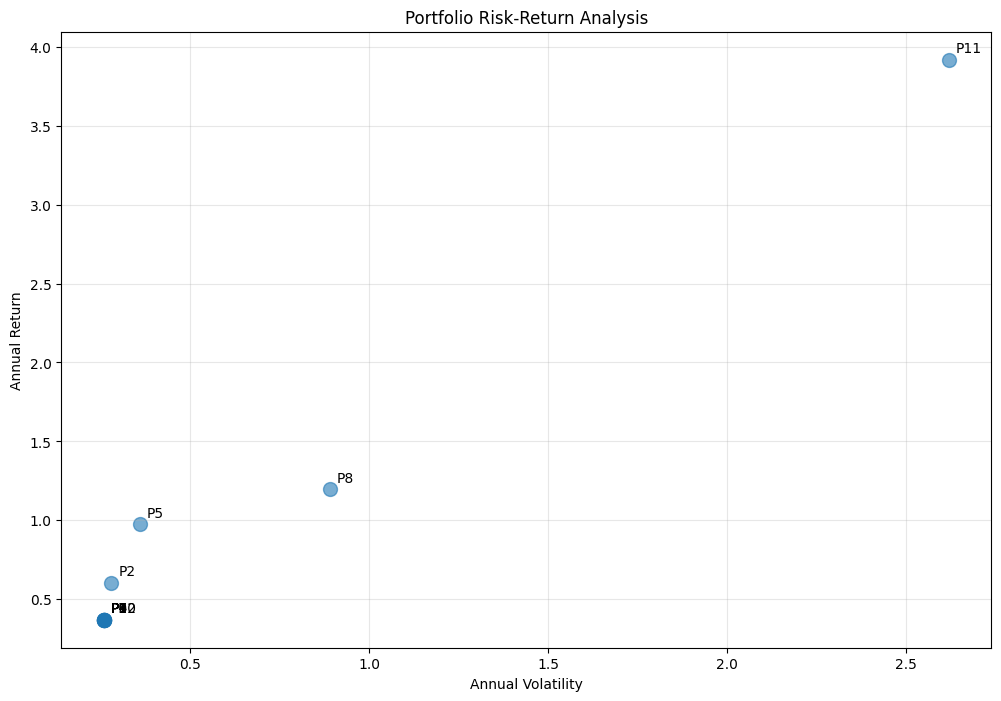

<Figure size 1400x800 with 0 Axes>

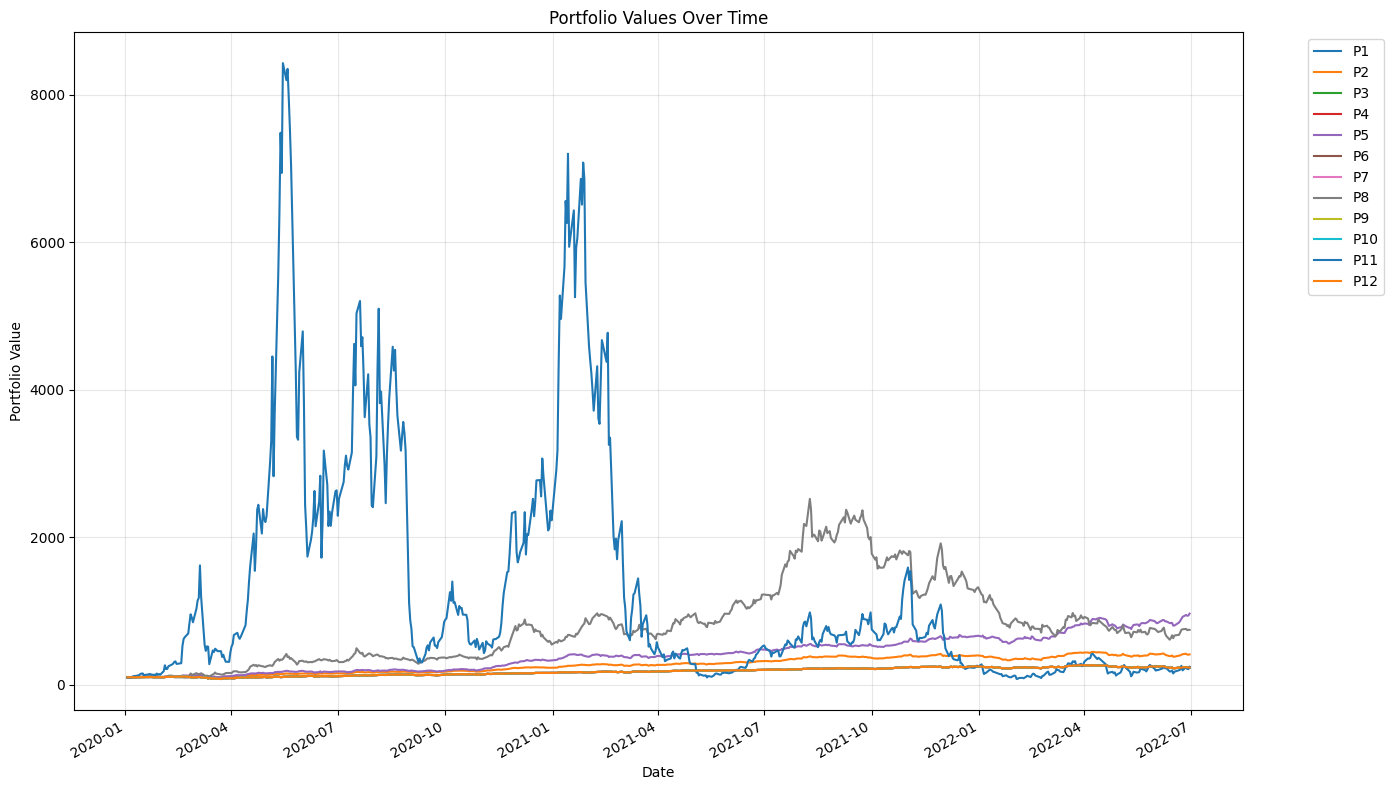

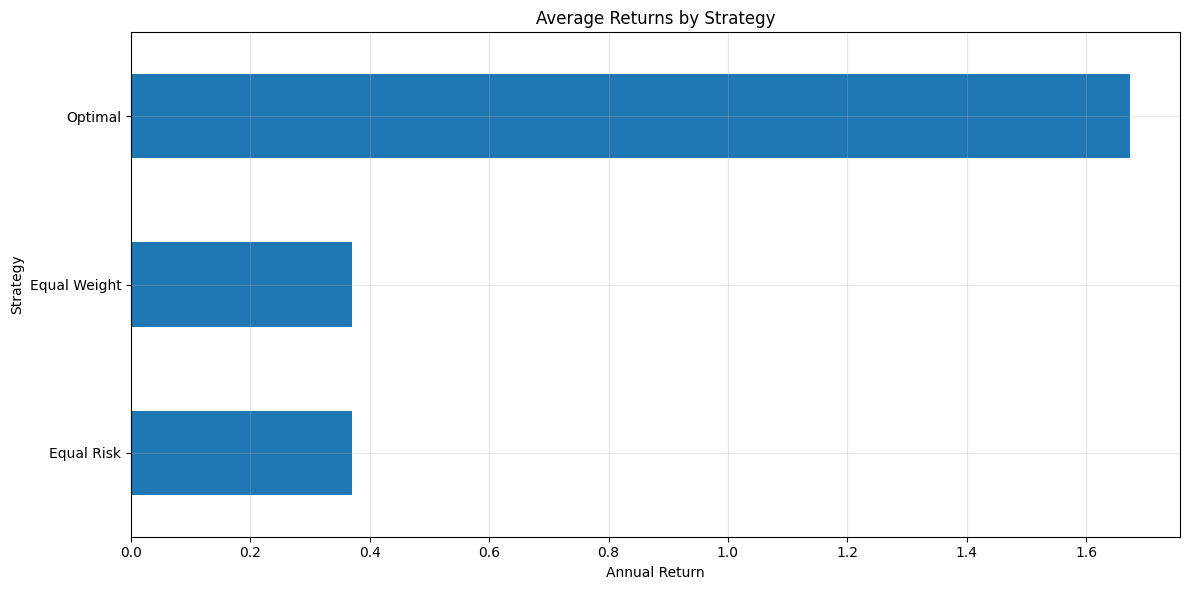

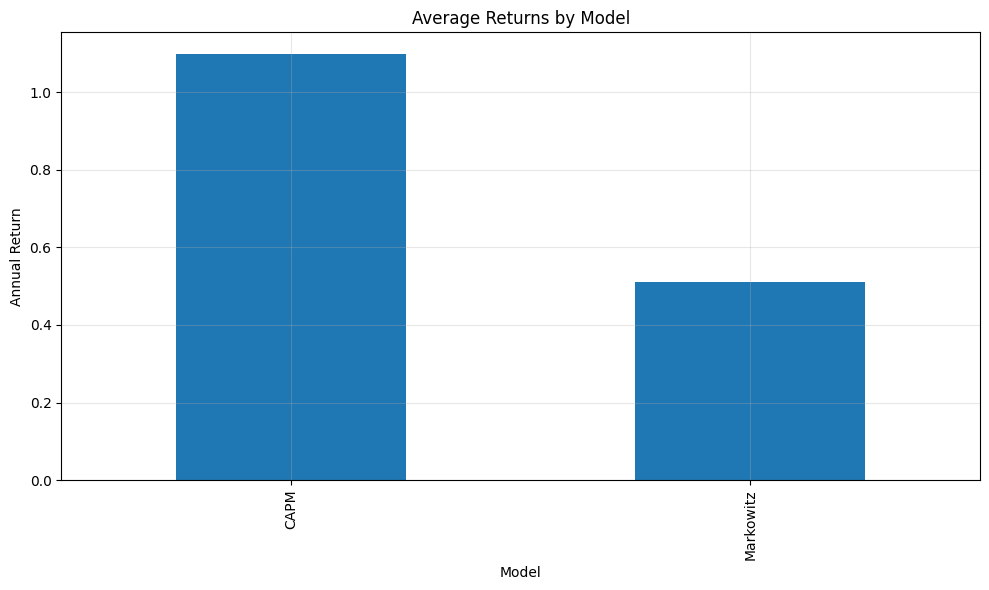

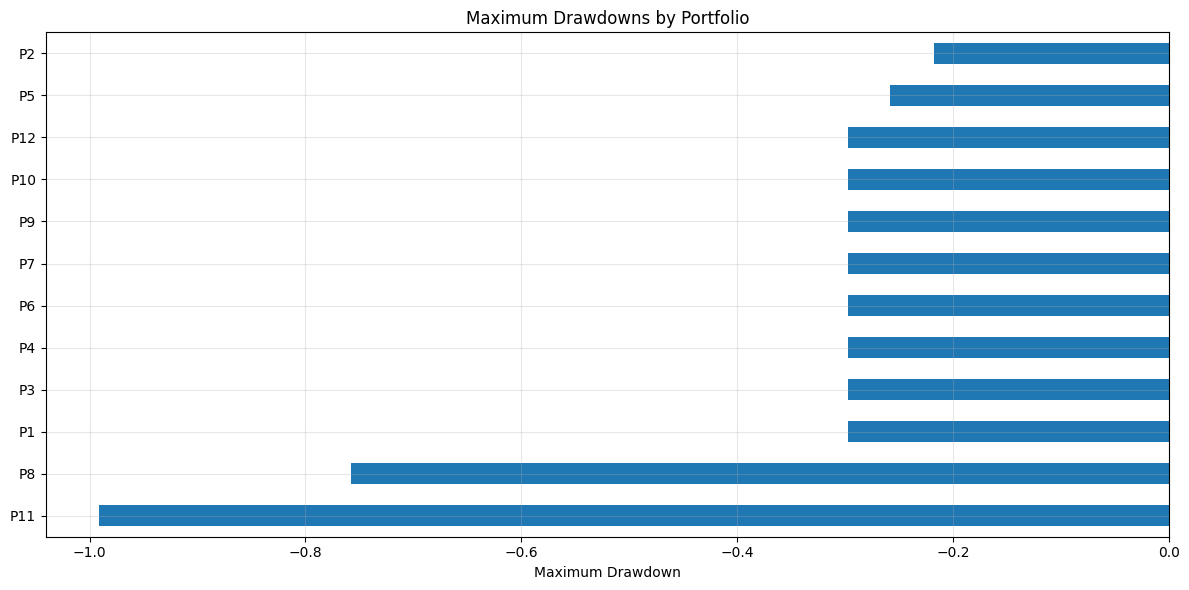

In [29]:
portfolios, portfolio_values, metrics, top_stocks = main()